In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import cv2
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, BatchNormalization, Conv2D, Softmax, Dropout, Input, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU, ZeroPadding2D, Reshape, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from livelossplot import PlotLossesKeras


In [10]:
#Constants
EPOCHS = 16
MODEL_FILE = "model.h5"
TRAINING_LOGS_FILE = "training_logs.csv"
VERBOSITY = 1
img_height = 227
img_width = 227
batch_size = 128
data_path = "./dataset/Cropped/"
train_output_directory = "./dataset/Augmented/train/"
validation_output_directory = "./dataset/Augmented/train/"

In [11]:
# Model architecture
input_layer = Input(shape=(img_height, img_width, 3), name="original_img")
# Left Most branch
conv01 = Conv2D(64, (3, 3), strides=2, padding='same')(input_layer)
leakyrelu01 = LeakyReLU(0.1)(conv01)
batchnorm01 = BatchNormalization(epsilon=0.00001)(leakyrelu01)
maxpool01 = MaxPooling2D(pool_size=6, strides=3, padding="same")(batchnorm01)
conv02 = Conv2D(128, (3, 3), strides=2, padding='same')(maxpool01)
leakyrelu02 = LeakyReLU(0.1)(conv02)
batchnorm02 = BatchNormalization(epsilon=0.00001)(leakyrelu02)
maxpool02 = MaxPooling2D(pool_size=(6, 6), strides=3, padding='same')(batchnorm02)
conv03 = Conv2D(224, (3, 3), strides=2, padding='same')(maxpool02)
leakyrelu03 = LeakyReLU(0.1)(conv03)
batchnorm03 = BatchNormalization(epsilon=0.00001)(leakyrelu03)
maxpool03 = MaxPooling2D(pool_size=(6, 6), strides=3, padding='same')(batchnorm03)

# Fully connected 1
fc_reshape = Reshape((1, 1, -1))(input_layer)
fc01 = Dense(16, activation='relu')(fc_reshape)
leakyrelu01_fc = LeakyReLU(0.1)(fc01)
batchnorm01_fc = BatchNormalization(epsilon=0.00001)(leakyrelu01_fc)
dropout01_fc = Dropout(0.2)(batchnorm01_fc)

zeropadding01 = ZeroPadding2D(padding=(2, 2))(dropout01_fc)
conv05 = Conv2D(64, (3, 3), strides=2)(zeropadding01)
leakyrelu05 = LeakyReLU(0.1)(conv05)
batchnorm05 = BatchNormalization(epsilon=0.00001)(leakyrelu05)

zeropadding02 = ZeroPadding2D(padding=(1, 1))(dropout01_fc)
conv04 = Conv2D(32, (2, 2), strides=1)(zeropadding02)
leakyrelu04 = LeakyReLU(0.1)(conv04)
batchnorm04 = BatchNormalization(epsilon=0.00001)(leakyrelu04)

depthcat01 = Concatenate()([batchnorm04, batchnorm05])
dropout02 = Dropout(0.2)(depthcat01)

# Combine Both branches
depthcat02 = Concatenate()([dropout02, maxpool03])
dropout03 = Dropout(0.2)(depthcat02)
conv07 = Conv2D(256, (1, 1), strides=1, padding='same')(dropout03)
leakyrelu07 = LeakyReLU(0.1)(conv07)
batchnorm07 = BatchNormalization(epsilon=0.00001)(leakyrelu07)
dropout07 = Dropout(0.3)(batchnorm07)

fc02_reshape = Reshape((1, 1, -1))(dropout07)
fc02 = Dense(512)(fc02_reshape)
leakyrelu02_fc = LeakyReLU(0.1)(fc02)
batchnorm02_fc = BatchNormalization(epsilon=0.00001)(leakyrelu02_fc)
dropout02_fc = Dropout(0.3)(batchnorm02_fc)

fc03 = Dense(4, activation='softmax')(dropout02_fc)
final_reshape = Reshape((4,))(fc03)

model = Model(input_layer, final_reshape, name="CCCN")


In [12]:
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "CCCN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 original_img (InputLayer)      [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 114, 114, 64  1792        ['original_img[0][0]']           
                                )                                                                 
                                                                                                  
 reshape_3 (Reshape)            (None, 1, 1, 154587  0           ['original_img[0][0]']           
                                )                                                              

                                                                                                  
 dropout_8 (Dropout)            (None, 2, 2, 256)    0           ['batch_normalization_14[0][0]'] 
                                                                                                  
 reshape_4 (Reshape)            (None, 1, 1, 1024)   0           ['dropout_8[0][0]']              
                                                                                                  
 dense_4 (Dense)                (None, 1, 1, 512)    524800      ['reshape_4[0][0]']              
                                                                                                  
 leaky_re_lu_15 (LeakyReLU)     (None, 1, 1, 512)    0           ['dense_4[0][0]']                
                                                                                                  
 batch_normalization_15 (BatchN  (None, 1, 1, 512)   2048        ['leaky_re_lu_15[0][0]']         
 ormalizat

In [13]:
# Data generators
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   validation_split=0.2)  # set validation split

train_generator = train_datagen.flow_from_directory(
    directory=data_path,
    save_to_dir=train_output_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')  # set as training data

validation_generator = train_datagen.flow_from_directory(
    directory=data_path,
    save_to_dir=validation_output_directory,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')  # set as validation data


Found 745 images belonging to 4 classes.
Found 183 images belonging to 4 classes.


In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


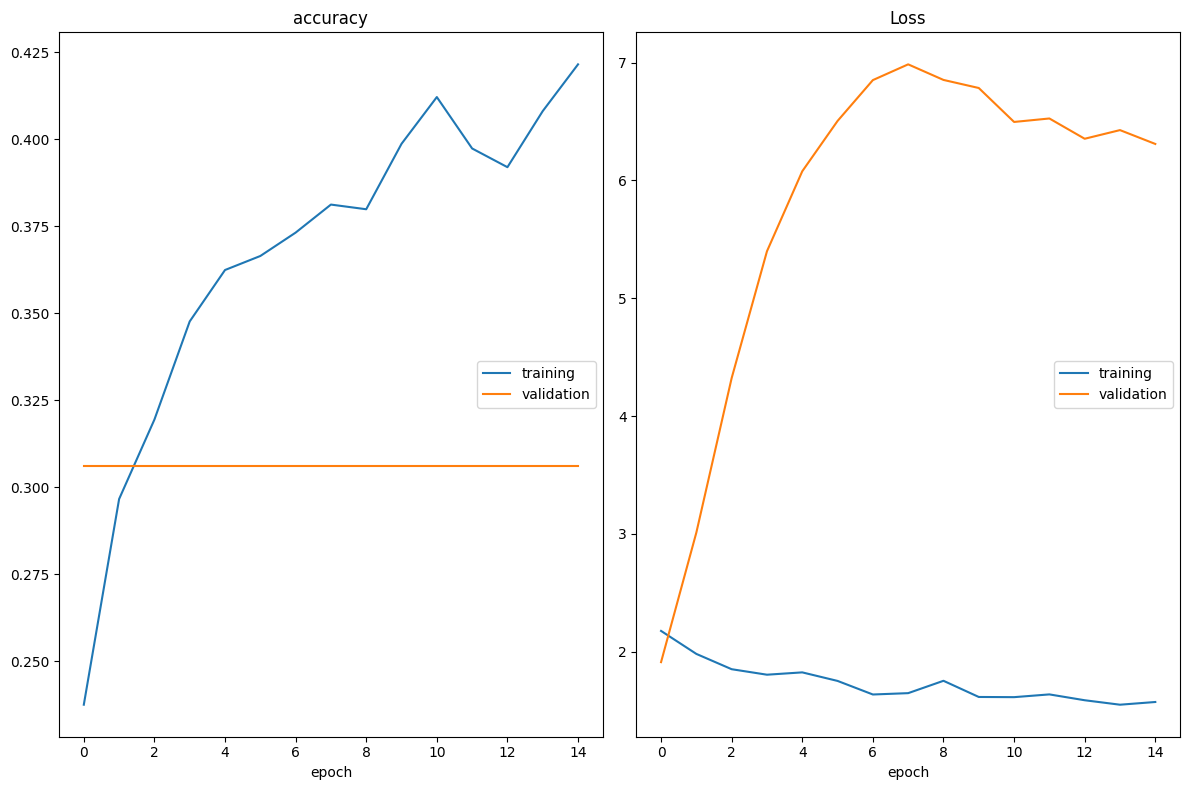

accuracy
	training         	 (min:    0.238, max:    0.421, cur:    0.421)
	validation       	 (min:    0.306, max:    0.306, cur:    0.306)
Loss
	training         	 (min:    1.551, max:    2.177, cur:    1.574)
	validation       	 (min:    1.913, max:    6.985, cur:    6.309)

Epoch 15: val_accuracy did not improve from 0.30601
6/6 [==============================] - 47s 8s/step - loss: 1.5743 - accuracy: 0.4215 - val_loss: 6.3093 - val_accuracy: 0.3060
Epoch 16/16


In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch=len(train_generator),
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator),
                    epochs=EPOCHS,
                    verbose=VERBOSITY,
                    callbacks=[PlotLossesKeras(),
                               ModelCheckpoint(MODEL_FILE,
                                               monitor='val_accuracy',
                                               verbose=VERBOSITY,
                                               save_best_only=True,
                                               mode='max'),
                               CSVLogger(TRAINING_LOGS_FILE,
                                         append=False,
                                         separator=',')
                               ])
# Print confirmation message
print("Training completed!")

In [9]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Verify if the directory exists
validation_directory = "./dataset/Augmented/"
if not os.path.exists(validation_directory):
    print("Validation directory does not exist.")